# Part 2: Data Preprocessing

In the last notebook, we sampled around 1.5 million rows of Yelp Reviews dataset, to create our Sentiment Analysis-based Recommender System while staying considerably within computational limits. In this notebook, we will use the sampled dataset and preprocess it.

## Importing Dependencies

In [ ]:
import pandas as pd
import contractions
import re
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from symspellpy import SymSpell, Verbosity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
import torch
import gc
import os
import numpy as np
from pathlib import Path

## Data Loading

In [ ]:
df = pd.read_parquet("yelp_reviews_sampled.parquet", engine="pyarrow")
print(df.shape)
df.head(10)

## Displaying and Identifying Duplicated Rows

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
same_user_same_business_same_text = df[df.duplicated(subset=['user_id', 'business_id', 'text'], keep=False)]
same_user_same_business_same_text = same_user_same_business_same_text.sort_values(['user_id', 'business_id', 'text', 'date']).reset_index(drop=True)

diff_users_same_text_same_business = df[df.duplicated(subset=['business_id', 'text'], keep=False)]
diff_users_same_text_same_business = diff_users_same_text_same_business.sort_values(['business_id', 'text', 'user_id', 'date']).reset_index(drop=True)

same_user_same_text_diff_business = df[df.duplicated(subset=['user_id', 'text'], keep=False)]
same_user_same_text_diff_business = same_user_same_text_diff_business.sort_values(['user_id', 'text', 'business_id', 'date']).reset_index(drop=True)

diff_users_same_text_diff_business = df[df.duplicated(subset=['text'], keep=False)]
diff_users_same_text_diff_business = diff_users_same_text_diff_business.sort_values(['text', 'user_id', 'business_id', 'date']).reset_index(drop=True)


In [ ]:
same_user_same_business_same_text

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,rMkcFd10-M5i-kjid92TSg,-Ac5aXhC1hXMTmm8G6xvYQ,yZHiutcbym-xLGkmFhP-9A,3,0,0,0,Frothy is raved about constantly by most hipst...,2015-08-13 14:04:23,neutral
1,CRDKukoWfQUyan_lvmxwjw,-Ac5aXhC1hXMTmm8G6xvYQ,yZHiutcbym-xLGkmFhP-9A,3,1,0,0,Frothy is raved about constantly by most hipst...,2015-09-28 00:54:43,neutral
2,BHZBzKu9AKUjUhuhk81_KQ,-BE-oVVhpJBzxmJTMLXxfg,iSRTaT9WngzB8JJ2YKJUig,1,0,0,0,SKIP THE GUMBO. Ordered a large gumbo and it w...,2019-09-15 03:28:19,negative
3,TEQrwWRnIJ4W9Vi7-uS6Nw,-BE-oVVhpJBzxmJTMLXxfg,iSRTaT9WngzB8JJ2YKJUig,1,0,0,0,SKIP THE GUMBO. Ordered a large gumbo and it w...,2020-09-27 23:54:24,negative
4,5AmycFK89hp3V-4CsvrePA,-G2beoyCbs_AOolyc-K8_g,V1o_BeHcTehuFD7ue-8H2A,3,0,0,0,If you want a good place to meet people and ta...,2017-08-27 13:37:07,neutral
...,...,...,...,...,...,...,...,...,...,...
1646,VBKakkU6nLxzzzCqELl8LA,zsXoPyTcU8ThZGbtAB-Vug,OvREyM6JzUogb8yQXXoF0A,5,1,0,1,Great value for lunchtime lots of food quick s...,2019-07-21 03:19:00,positive
1647,829KOBIuxesjFikoS0Llyg,zu-e06_BM_TdkAZEKMrIww,7EDmyx7vC7FYKkkxQEdkzQ,3,2,0,0,Decent cycle studio in Tampa. The studio is ma...,2017-12-25 17:14:12,neutral
1648,ID-uYFviFBeEXFFHUAvtiw,zu-e06_BM_TdkAZEKMrIww,7EDmyx7vC7FYKkkxQEdkzQ,3,5,1,1,Decent cycle studio in Tampa. The studio is ma...,2017-12-28 04:30:52,neutral
1649,t8xtEHe7LNBH-nVQQRE8CA,zwlhMq1boxVmjjK5ULihxQ,QLUUaTj034zYVWiVl9tNvA,5,0,0,0,"Seriously impressed with the food, good drinks...",2018-04-02 21:40:46,positive


In [ ]:
diff_users_same_text_same_business

# 68

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,Y4buajRcmNLXG-XhLb650w,ng15Bty1Xh_NjessNvJrdA,-0iIxySkp97WNlwK66OGWg,5,1,0,0,"Cheesy, bacony and spicy: these words describe...",2018-06-17 02:40:02,positive
1,meQDo1me5FEJb3RRaU5qAA,ng15Bty1Xh_NjessNvJrdA,-0iIxySkp97WNlwK66OGWg,5,2,0,3,"Cheesy, bacony and spicy: these words describe...",2018-08-03 18:40:23,positive
2,x6b5NgwuHOX7KJiWM-Zruw,CsVpAEIpymc2grb9i521uA,-0iIxySkp97WNlwK66OGWg,3,0,0,1,"Look, promote what's local, promote what's goo...",2017-11-22 02:20:23,neutral
3,N4gOXNIdwphDDoqDhi0UaQ,CsVpAEIpymc2grb9i521uA,-0iIxySkp97WNlwK66OGWg,4,0,0,0,"Look, promote what's local, promote what's goo...",2018-05-25 15:33:12,positive
4,okRveMjnuZe-VoNJqsb59Q,ff-lkEG396nmrd7aHcBEvQ,-3xX_IfttKjPJ792BOBJ-Q,3,1,0,0,The food is always right on! But the customer...,2014-02-19 04:48:26,neutral
...,...,...,...,...,...,...,...,...,...,...
1684,g4fI01uqnSxPiYJOciAb3g,jXJ524KA26F3h8QS94Rlxw,zlNtAPz4GvSUiljQ-D3cvQ,1,1,0,0,Went to this restaurant while visiting New Orl...,2018-10-20 23:12:44,negative
1685,SLV7uZj0Nw8VthIJlUmTQg,YhBYgcu7vS0mwEX8TOOZSA,zwBvdDWFQpYJE1UMDTlSyw,5,0,0,0,"The Impossible Burger and the spicy Philly ""ch...",2018-10-02 17:24:17,positive
1686,GG3-0k9FGMq1Q6YlVslWGA,YhBYgcu7vS0mwEX8TOOZSA,zwBvdDWFQpYJE1UMDTlSyw,5,1,0,1,"The Impossible Burger and the spicy Philly ""ch...",2019-06-04 16:11:44,positive
1687,zzstF6X4o3TaWEq0bfEcDA,w1F944UMHw1KfwKflIe2mQ,zxPcNvM4aPZu6gUmTFkazQ,2,1,0,0,Came her for another visit for lunch. Appeared...,2017-05-02 01:33:37,negative


In [ ]:
same_user_same_text_diff_business

# 18

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,rMkcFd10-M5i-kjid92TSg,-Ac5aXhC1hXMTmm8G6xvYQ,yZHiutcbym-xLGkmFhP-9A,3,0,0,0,Frothy is raved about constantly by most hipst...,2015-08-13 14:04:23,neutral
1,CRDKukoWfQUyan_lvmxwjw,-Ac5aXhC1hXMTmm8G6xvYQ,yZHiutcbym-xLGkmFhP-9A,3,1,0,0,Frothy is raved about constantly by most hipst...,2015-09-28 00:54:43,neutral
2,BHZBzKu9AKUjUhuhk81_KQ,-BE-oVVhpJBzxmJTMLXxfg,iSRTaT9WngzB8JJ2YKJUig,1,0,0,0,SKIP THE GUMBO. Ordered a large gumbo and it w...,2019-09-15 03:28:19,negative
3,TEQrwWRnIJ4W9Vi7-uS6Nw,-BE-oVVhpJBzxmJTMLXxfg,iSRTaT9WngzB8JJ2YKJUig,1,0,0,0,SKIP THE GUMBO. Ordered a large gumbo and it w...,2020-09-27 23:54:24,negative
4,5AmycFK89hp3V-4CsvrePA,-G2beoyCbs_AOolyc-K8_g,V1o_BeHcTehuFD7ue-8H2A,3,0,0,0,If you want a good place to meet people and ta...,2017-08-27 13:37:07,neutral
...,...,...,...,...,...,...,...,...,...,...
2114,sJ0qctlo9jTm-ExF5nU-XA,zwPfkbldCt-VFHawHU_ivQ,pWoXaLokwdPD7nLYl1ffaA,5,1,0,1,I called AAA about 8;30 to get my Ford Coachma...,2019-12-04 18:16:21,positive
2115,t8xtEHe7LNBH-nVQQRE8CA,zwlhMq1boxVmjjK5ULihxQ,QLUUaTj034zYVWiVl9tNvA,5,0,0,0,"Seriously impressed with the food, good drinks...",2018-04-02 21:40:46,positive
2116,uDU--x8u8kmOo9CDXeq3vw,zwlhMq1boxVmjjK5ULihxQ,QLUUaTj034zYVWiVl9tNvA,5,0,0,0,"Seriously impressed with the food, good drinks...",2018-12-31 09:44:37,positive
2117,OItq2vU_D0wByMTClsu82g,zzAJb1SyZKQp5qOQ0EJjxA,7WTy8p_Uc_iVDKugJc59oA,1,0,0,0,I strongly do not recommend this store. I aske...,2020-11-24 18:02:45,negative


In [ ]:
diff_users_same_text_diff_business

# 12

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,xUR9r9_vVb9EwcXlu-yaLA,5RZDMSpeMNEJcgtgMxzGDQ,TjXbh5PwgCOFkvbi0_qrmA,1,1,0,0,!!!!!!!! !!!!!!!! !!!!!!!Do not eat here I wa...,2018-06-06 00:52:54,negative
1,RHxAvqe7npDBxVVff5VRWA,5RZDMSpeMNEJcgtgMxzGDQ,TjXbh5PwgCOFkvbi0_qrmA,1,3,0,1,!!!!!!!! !!!!!!!! !!!!!!!Do not eat here I wa...,2018-06-26 22:23:27,negative
2,Axpkyl30Cvx6TZbX3wovHw,j417Fkcu09vU11qlHSyayg,wdO59jXr1uulOCJ9Pwc0UQ,2,1,0,0,$ 130 to replace one fuse. When I drove away I...,2012-02-28 20:30:46,negative
3,jb0aL38zpdzF1LfZ7sIW6w,j417Fkcu09vU11qlHSyayg,wdO59jXr1uulOCJ9Pwc0UQ,2,2,0,1,$ 130 to replace one fuse. When I drove away I...,2012-03-02 19:25:20,negative
4,k7EbZBIAaFEtxC-viRIaWQ,T6QKE7SnJEhTEOq0Y8tICw,BEMSDLPP630Fpdw_QpqLVA,2,0,0,0,$5 for a cafe con leche that was small and jus...,2016-11-11 17:18:06,negative
...,...,...,...,...,...,...,...,...,...,...
2166,QsO7Tc8su05FSlykYeDM8g,_ftC02Ie9tu3TuvaULuyZg,XHz5zlt4SDYr64aLDBx6Vg,1,0,0,0,the steak here is horrendous. This is the seco...,2016-03-27 23:21:55,negative
2167,pLcc78lh2oxDJP2s2AD5jQ,wqkCYci3gYEgYY8-MTDlBA,y_G0xkomswVQaejYp4Fy4g,2,0,0,0,the workers are nice but my gel manicure chipp...,2019-01-28 21:17:15,negative
2168,f94zC1kz06Ew7XAZbYjPog,wqkCYci3gYEgYY8-MTDlBA,y_G0xkomswVQaejYp4Fy4g,3,0,0,0,the workers are nice but my gel manicure chipp...,2019-02-08 02:10:24,neutral
2169,GJ1UbcofodYDtW0asJA9Jg,XrRzoHW4T-9l4CEzAZ8cxA,YyibusgZiK47Gr33c0yipw,3,0,0,0,"this place is back open and is now ""La Parrill...",2015-05-08 16:28:32,neutral


In [ ]:
df = df.sort_values('date').drop_duplicates(subset=['user_id', 'business_id', 'text'], keep='last')
df = df.drop_duplicates(subset=['business_id', 'text'], keep='first')
df = df.drop_duplicates(subset=['user_id', 'text'], keep='first')
df = df.drop_duplicates(subset=['text'], keep='first')

In [ ]:
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
1288042,-O5ng1XLox6uEr4uIZ8u5A,3zBJUlWtPNoZ0uN83ODbyg,3g6XqkBikTTbZmTukbeGnw,4,1,0,0,Great service. The people really want to help...,2005-02-16 03:29:39,positive
445151,WC9q5vhQlQkLK05kEs-vYQ,XCsZ3hWa_6oP1WkWvK7pmg,Aes-0Q_guDeYewMapFs_vg,2,0,0,0,Food is decent but is a complete tourist trap....,2005-03-01 16:59:37,negative
873049,Q0GJ06L78nkVyNfHrd9iUg,XCsZ3hWa_6oP1WkWvK7pmg,CziOtnFSklimJnBgksDDwA,3,0,0,0,"This place gets a 3.5...great location, great ...",2005-03-01 17:25:13,neutral
706408,-wsNpVhc3D-wDmBXRwnGTw,3MYdpmHeNwC6FquRWi3YOg,ZPwFVWoiqFOTbnhfSuK-ZQ,2,1,2,0,Un-safeway. Meet homeless people and drug add...,2005-03-02 04:53:42,negative
535320,FfzcGEJ1pYUx8jy0BDAW9Q,3MYdpmHeNwC6FquRWi3YOg,ajfmcCilbPMKb_VxswIuQQ,3,0,0,0,"A hippie coffee store, but with free wifi. Al...",2005-03-04 02:16:43,neutral
...,...,...,...,...,...,...,...,...,...,...
1209076,CjY4dvNC5Y1m5UpXQCtznA,QKiIQoReb7e6oWYUbeJb_A,Lj0oSzrim8zGPozHbfbLyA,1,0,0,0,"Ordered my meal and waited, another person tha...",2022-01-19 19:22:44,negative
974552,YfP1m0N2zpywkdXHXP6DvA,niT8rvECKTyNQodb9uMrgw,wZFTq5MMzuJqqMIfeux9bA,1,0,0,0,Please steer clear of this place. I have 16 t...,2022-01-19 19:30:49,negative
1111616,THBOqgQHg5XD2-n0n0StlQ,teauejBc7ynvX_oBuAJl1g,NGMLSJq_qDgFfZc2-4xwEg,1,0,0,0,I am so angry right now. I would rate this st...,2022-01-19 19:43:47,negative
1442716,y2MsWZ3Af8tOywtg0FXXfg,MfQc-rOY5Qu_uRcoXDNzKA,dcHPZZ6lgqm_VAcQjOUoMg,5,0,0,0,"Absolutely love this shop, always helpful been...",2022-01-19 19:46:06,positive


## Removing irrelevant characters and corrupted rows

In [ ]:
df['text'] = df['text'].str.replace(r'[\(\)\[\]{}<>]', '', regex=True)
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
df = df.reset_index(drop=True)

In [ ]:
df = df[~df['text'].str.match(r'^[^\w]*$', na=False)]

In [ ]:
df['text'] = df['text'].str.lower()

## Number Normalization

In [ ]:
df[df['text'].str.contains(r'\d', regex=True)]

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
2,Q0GJ06L78nkVyNfHrd9iUg,XCsZ3hWa_6oP1WkWvK7pmg,CziOtnFSklimJnBgksDDwA,3,0,0,0,"this place gets a 3.5...great location, great ...",2005-03-01 17:25:13,neutral
17,BHmyv9NdA24zpB72GlsySw,3MYdpmHeNwC6FquRWi3YOg,F4Pk3sNtkPCYLColKYpuwQ,1,0,0,0,there are always 4 employees stuffed in the cl...,2005-03-12 18:18:34,negative
23,0djAd_YG1EVbbvVsv7vJjA,3zBJUlWtPNoZ0uN83ODbyg,XScJI9exHgC0u_c3vmm1vQ,3,0,2,0,"dude, i made like 8 dollars in profit at harra...",2005-03-16 04:26:19,neutral
24,vxW3l9QNpg27lcK7FEqHiA,9Z2UEd_f6eC17YxifpWfMw,XScJI9exHgC0u_c3vmm1vQ,3,0,0,0,casinos suck! this was the first time i've gam...,2005-03-16 04:29:09,neutral
26,Uc1C5BBmYOw6ZyaDm2MMbw,3MYdpmHeNwC6FquRWi3YOg,5vpqoHruyjHALHjxJLSJbA,1,0,1,0,i once went to this gavi and it was fine. seco...,2005-04-03 05:14:30,negative
...,...,...,...,...,...,...,...,...,...,...
1498885,qXREs--20x_QtMFZjl0zsg,QLU-88WwG4hKj6jKSR8iig,cHEHjDU4biZxiEyglZL9lw,1,0,0,0,flew from california to buy a certified pre ow...,2022-01-19 18:54:15,negative
1498889,kf74scvy40xYYizHp52bZA,aLpFOC0NIGYoulfmSINn4w,ncqjFACGWbWzDWSUyIcX_A,3,0,0,0,pros: great customer service/price/timing cons...,2022-01-19 19:12:08,neutral
1498891,QbPBkY_FglAoi3GQKS1Gbw,TK9sssxXkq4T7Kl2xFRwAg,B10mqANgHvL8gBteo1UhAA,3,0,0,0,the wine list and wine by the glass offerings ...,2022-01-19 19:21:05,neutral
1498895,YfP1m0N2zpywkdXHXP6DvA,niT8rvECKTyNQodb9uMrgw,wZFTq5MMzuJqqMIfeux9bA,1,0,0,0,please steer clear of this place. i have 16 th...,2022-01-19 19:30:49,negative


In [ ]:
def replace_numbers(text):
    text = re.sub(r'(?<!\w)\$?\d+(\.\d+)?(?!\w|\s*star)', '[NUM]', text)
    
    return text

df['text'] = df['text'].apply(replace_numbers)

In [ ]:
df[df['text'].str.contains(r'\d', regex=True)]

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
63,jm2vtxy3cmHonLMgUgSz_Q,58yhbFfNHjULDZx0FD-Dvw,gnEyjxoBYQcP9Bz72C95YA,4,0,0,0,"in my opinion, the best bar to hang out at on ...",2005-06-08 06:12:17,positive
71,I8nxuFm-Vi2o7JfM0E_YWA,H4JNrBAoyCk_ZMZWbAf8OA,T9C1od-JorSPXwXgzSqM9Q,3,2,0,1,mai lai wah is open till the wee hours of the ...,2005-07-06 21:27:49,neutral
105,MSt3hkzLBmIy8b8VwXlC7Q,n-lBS02-3yvlY5Q91mmwDA,pym7c6ZFEtmoH16xN2ApBg,3,0,0,0,katie's is a neighborhood restaurant that has ...,2005-07-10 21:25:46,neutral
119,Q8D1QPQF0JL6B90wZlpjEQ,n-lBS02-3yvlY5Q91mmwDA,rGpDkBpwiuhgxOdBqol1Iw,3,6,0,2,pepper keenan of corosion of conformity bought...,2005-07-11 02:44:50,neutral
133,wJP3YmZVg13fsQstC5TkpQ,-2BsDZWzob5Q1ZGHcDJ6gw,eN-Zrz1orLoqIb7D6mUMbg,4,1,0,0,brooklyn pizza co. has the best new york style...,2005-07-15 16:46:08,positive
...,...,...,...,...,...,...,...,...,...,...
1498861,5XW3yoiGehWUKuVF3uhlDw,W1AFbtC37Q1RzdrKS51NmQ,GJUSPJThoiOd4FsXvMvB4w,5,1,0,1,this place is way better than the yelp rating ...,2022-01-19 17:58:20,positive
1498864,DZOcpl3hAhnoBbDE1_BL7w,U76IFozArZsShdmoIdDMUw,oAvDW5QvC4YyIz7P6LBJFw,1,0,0,0,terrible customer service. we had granite coun...,2022-01-19 18:00:24,negative
1498866,CsgTGpck1ROBXRaOXIOfwQ,cco5VSBNHfow4jfLgjZG8A,pXGjRlMs6Nzn59GUeDKsxQ,1,0,0,0,booked a [NUM] day stay at this hotel through ...,2022-01-19 18:06:32,negative
1498885,qXREs--20x_QtMFZjl0zsg,QLU-88WwG4hKj6jKSR8iig,cHEHjDU4biZxiEyglZL9lw,1,0,0,0,flew from california to buy a certified pre ow...,2022-01-19 18:54:15,negative


## Expanding Contractions

In [ ]:
def expand_contractions(text):
    return contractions.fix(text)

df['text'] = df['text'].apply(expand_contractions)

In [ ]:
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,-O5ng1XLox6uEr4uIZ8u5A,3zBJUlWtPNoZ0uN83ODbyg,3g6XqkBikTTbZmTukbeGnw,4,1,0,0,great service. the people really want to help ...,2005-02-16 03:29:39,positive
1,WC9q5vhQlQkLK05kEs-vYQ,XCsZ3hWa_6oP1WkWvK7pmg,Aes-0Q_guDeYewMapFs_vg,2,0,0,0,food is decent but is a complete tourist trap....,2005-03-01 16:59:37,negative
2,Q0GJ06L78nkVyNfHrd9iUg,XCsZ3hWa_6oP1WkWvK7pmg,CziOtnFSklimJnBgksDDwA,3,0,0,0,"this place gets a [NUM]...great location, grea...",2005-03-01 17:25:13,neutral
3,-wsNpVhc3D-wDmBXRwnGTw,3MYdpmHeNwC6FquRWi3YOg,ZPwFVWoiqFOTbnhfSuK-ZQ,2,1,2,0,un-safeway. meet homeless people and drug addi...,2005-03-02 04:53:42,negative
4,FfzcGEJ1pYUx8jy0BDAW9Q,3MYdpmHeNwC6FquRWi3YOg,ajfmcCilbPMKb_VxswIuQQ,3,0,0,0,"a hippie coffee store, but with free wifi. als...",2005-03-04 02:16:43,neutral
...,...,...,...,...,...,...,...,...,...,...
1498894,CjY4dvNC5Y1m5UpXQCtznA,QKiIQoReb7e6oWYUbeJb_A,Lj0oSzrim8zGPozHbfbLyA,1,0,0,0,"ordered my meal and waited, another person tha...",2022-01-19 19:22:44,negative
1498895,YfP1m0N2zpywkdXHXP6DvA,niT8rvECKTyNQodb9uMrgw,wZFTq5MMzuJqqMIfeux9bA,1,0,0,0,please steer clear of this place. i have [NUM]...,2022-01-19 19:30:49,negative
1498896,THBOqgQHg5XD2-n0n0StlQ,teauejBc7ynvX_oBuAJl1g,NGMLSJq_qDgFfZc2-4xwEg,1,0,0,0,i am so angry right now. i would rate this sto...,2022-01-19 19:43:47,negative
1498897,y2MsWZ3Af8tOywtg0FXXfg,MfQc-rOY5Qu_uRcoXDNzKA,dcHPZZ6lgqm_VAcQjOUoMg,5,0,0,0,"absolutely love this shop, always helpful been...",2022-01-19 19:46:06,positive


In [ ]:
df.isna().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
sentiment      0
dtype: int64

## Correcting Common Words

In [ ]:
! wget https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_dictionary_en_82_765.txt

--2025-04-13 14:08:51--  https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_dictionary_en_82_765.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332879 (1.3M) [text/plain]
Saving to: ‘frequency_dictionary_en_82_765.txt.2’

frequency_dictionar 100%[===================>]   1.27M  5.29MB/s    in 0.2s    

2025-04-13 14:08:53 (5.29 MB/s) - ‘frequency_dictionary_en_82_765.txt.2’ saved [1332879/1332879]



In [ ]:
tqdm.pandas()

sym_spell = SymSpell()
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt", 0, 1)

def symspell_correct(text):
    words = text.split()
    corrected_words = [sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)[0].term if sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2) else word for word in words]
    return " ".join(corrected_words)

df['text'] = df['text'].progress_apply(symspell_correct)


  0%|          | 0/1498897 [00:00<?, ?it/s]

In [ ]:
df.to_parquet("yelp_preprocessed.parquet", engine="pyarrow", index=False)

## Class Distribution

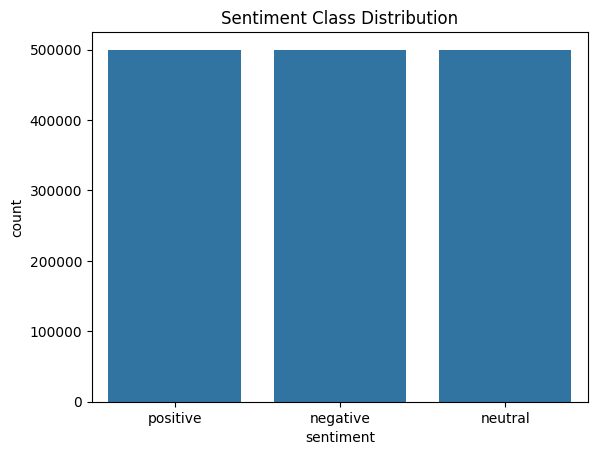

In [ ]:
sns.countplot(x=df['sentiment'])
plt.title("Sentiment Class Distribution")
plt.show()

## Reviews Word Length Distribution

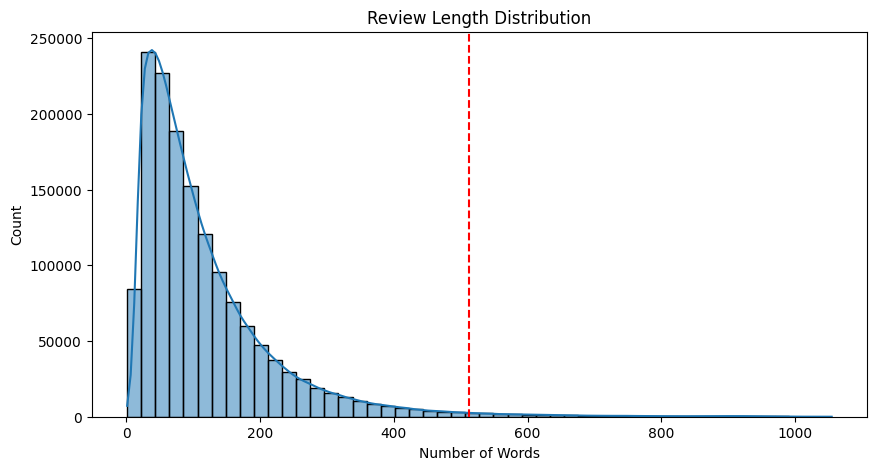

In [3]:
df['review_length'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.axvline(512, color='r', linestyle='dashed')  # BERT limit
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

## Label Encoding of Sentiments

In [ ]:
df = pd.read_parquet('yelp_preprocessed.parquet')

In [2]:
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,-O5ng1XLox6uEr4uIZ8u5A,3zBJUlWtPNoZ0uN83ODbyg,3g6XqkBikTTbZmTukbeGnw,4,1,0,0,great services the people really want to help ...,2005-02-16 03:29:39,positive
1,WC9q5vhQlQkLK05kEs-vYQ,XCsZ3hWa_6oP1WkWvK7pmg,Aes-0Q_guDeYewMapFs_vg,2,0,0,0,food is decent but is a complete tourist trap ...,2005-03-01 16:59:37,negative
2,Q0GJ06L78nkVyNfHrd9iUg,XCsZ3hWa_6oP1WkWvK7pmg,CziOtnFSklimJnBgksDDwA,3,0,0,0,this place gets a [NUM]...great location great...,2005-03-01 17:25:13,neutral
3,-wsNpVhc3D-wDmBXRwnGTw,3MYdpmHeNwC6FquRWi3YOg,ZPwFVWoiqFOTbnhfSuK-ZQ,2,1,2,0,un-safeway. meet homeless people and drug addi...,2005-03-02 04:53:42,negative
4,FfzcGEJ1pYUx8jy0BDAW9Q,3MYdpmHeNwC6FquRWi3YOg,ajfmcCilbPMKb_VxswIuQQ,3,0,0,0,a hippie coffee store but with free wifi also ...,2005-03-04 02:16:43,neutral
...,...,...,...,...,...,...,...,...,...,...
1498892,CjY4dvNC5Y1m5UpXQCtznA,QKiIQoReb7e6oWYUbeJb_A,Lj0oSzrim8zGPozHbfbLyA,1,0,0,0,ordered my meal and waited another person that...,2022-01-19 19:22:44,negative
1498893,YfP1m0N2zpywkdXHXP6DvA,niT8rvECKTyNQodb9uMrgw,wZFTq5MMzuJqqMIfeux9bA,1,0,0,0,please steer clear of this place i have [NUM] ...,2022-01-19 19:30:49,negative
1498894,THBOqgQHg5XD2-n0n0StlQ,teauejBc7ynvX_oBuAJl1g,NGMLSJq_qDgFfZc2-4xwEg,1,0,0,0,i am so angry right now i would rate this stor...,2022-01-19 19:43:47,negative
1498895,y2MsWZ3Af8tOywtg0FXXfg,MfQc-rOY5Qu_uRcoXDNzKA,dcHPZZ6lgqm_VAcQjOUoMg,5,0,0,0,absolutely love this shop always helpful been ...,2022-01-19 19:46:06,positive


In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])

In [4]:
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment,label
0,-O5ng1XLox6uEr4uIZ8u5A,3zBJUlWtPNoZ0uN83ODbyg,3g6XqkBikTTbZmTukbeGnw,4,1,0,0,great services the people really want to help ...,2005-02-16 03:29:39,positive,2
1,WC9q5vhQlQkLK05kEs-vYQ,XCsZ3hWa_6oP1WkWvK7pmg,Aes-0Q_guDeYewMapFs_vg,2,0,0,0,food is decent but is a complete tourist trap ...,2005-03-01 16:59:37,negative,0
2,Q0GJ06L78nkVyNfHrd9iUg,XCsZ3hWa_6oP1WkWvK7pmg,CziOtnFSklimJnBgksDDwA,3,0,0,0,this place gets a [NUM]...great location great...,2005-03-01 17:25:13,neutral,1
3,-wsNpVhc3D-wDmBXRwnGTw,3MYdpmHeNwC6FquRWi3YOg,ZPwFVWoiqFOTbnhfSuK-ZQ,2,1,2,0,un-safeway. meet homeless people and drug addi...,2005-03-02 04:53:42,negative,0
4,FfzcGEJ1pYUx8jy0BDAW9Q,3MYdpmHeNwC6FquRWi3YOg,ajfmcCilbPMKb_VxswIuQQ,3,0,0,0,a hippie coffee store but with free wifi also ...,2005-03-04 02:16:43,neutral,1
...,...,...,...,...,...,...,...,...,...,...,...
1498892,CjY4dvNC5Y1m5UpXQCtznA,QKiIQoReb7e6oWYUbeJb_A,Lj0oSzrim8zGPozHbfbLyA,1,0,0,0,ordered my meal and waited another person that...,2022-01-19 19:22:44,negative,0
1498893,YfP1m0N2zpywkdXHXP6DvA,niT8rvECKTyNQodb9uMrgw,wZFTq5MMzuJqqMIfeux9bA,1,0,0,0,please steer clear of this place i have [NUM] ...,2022-01-19 19:30:49,negative,0
1498894,THBOqgQHg5XD2-n0n0StlQ,teauejBc7ynvX_oBuAJl1g,NGMLSJq_qDgFfZc2-4xwEg,1,0,0,0,i am so angry right now i would rate this stor...,2022-01-19 19:43:47,negative,0
1498895,y2MsWZ3Af8tOywtg0FXXfg,MfQc-rOY5Qu_uRcoXDNzKA,dcHPZZ6lgqm_VAcQjOUoMg,5,0,0,0,absolutely love this shop always helpful been ...,2022-01-19 19:46:06,positive,2


## Data Splitting

In [ ]:

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    val_texts, val_labels, test_size=0.5, stratify=val_labels, random_state=42)


## Tokenization using BERT

In [ ]:
def tokenize(texts, output_path, desc="Tokenizing", batch_size=64, max_length=512):
    tokenizer = AutoTokenizer.from_pretrained("roberta-base", use_fast=True)
    total = len(texts)

    tmp_dir = Path("./tmp_tokenizer")
    tmp_dir.mkdir(exist_ok=True)

    input_ids_file = f"{tmp_dir}/tmp_input_ids.npy"
    attention_mask_file = f"{tmp_dir}/tmp_attention_mask.npy"

    try:
        input_ids_mmap = np.memmap(
            input_ids_file,
            dtype=np.int32,
            mode='w+',
            shape=(total, max_length)
        )

        attention_mask_mmap = np.memmap(
            attention_mask_file,
            dtype=np.int32,
            mode='w+',
            shape=(total, max_length)
        )

        with torch.no_grad():
            for i in tqdm(range(0, total, batch_size), desc=desc):
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

                end_idx = min(i + batch_size, total)
                batch = texts[i:end_idx]

                encoded = tokenizer(
                    batch,
                    truncation=True,
                    padding='max_length',
                    max_length=max_length,
                    return_tensors='pt',
                    add_special_tokens=True,
                    return_attention_mask=True
                )

                input_ids_mmap[i:end_idx] = encoded['input_ids'].numpy()
                attention_mask_mmap[i:end_idx] = encoded['attention_mask'].numpy()

                input_ids_mmap.flush()
                attention_mask_mmap.flush()

                del encoded, batch
                gc.collect()

        del input_ids_mmap
        del attention_mask_mmap
        gc.collect()

        print(f"Converting to tensors and saving to {output_path}")

        input_ids = torch.from_numpy(
            np.memmap(input_ids_file, dtype=np.int32, mode='r').reshape(total, max_length)
        ).clone()

        attention_mask = torch.from_numpy(
            np.memmap(attention_mask_file, dtype=np.int32, mode='r').reshape(total, max_length)
        ).clone()

        result = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

        torch.save(result, output_path)
        print(f"Successfully saved to {output_path}")

    finally:
        if os.path.exists(input_ids_file):
            os.remove(input_ids_file)
        if os.path.exists(attention_mask_file):
            os.remove(attention_mask_file)

        try:
            os.rmdir(tmp_dir)
        except OSError:
            pass

def process_all_datasets(train_texts, val_texts, test_texts):
    print("Processing training data")
    tokenize(
        train_texts.to_list(),
        "train_encodings.pt",
        "Tokenizing Train",
        batch_size=1024
    )
    gc.collect()

    print("Processing validation data")
    tokenize(
        val_texts.to_list(),
        "val_encodings.pt",
        "Tokenizing Val",
        batch_size=1024
    )
    gc.collect()

    print("Processing test data")
    tokenize(
        test_texts.to_list(),
        "test_encodings.pt",
        "Tokenizing Test",
        batch_size=1024
    )

    print("All processing completed!")

In [ ]:
process_all_datasets(train_texts, val_texts, test_texts)

Tokenizing Train:   0%|          | 0/37473 [00:00<?, ?it/s]

In [ ]:
!cp train_encodings.pt /content/drive/MyDrive/
!cp val_encodings.pt /content/drive/MyDrive/
!cp test_encodings.pt /content/drive/MyDrive/

In [ ]:
torch.save(torch.tensor(train_labels.to_numpy()), "/content/drive/MyDrive/train_labels.pt")
torch.save(torch.tensor(val_labels.to_numpy()), "/content/drive/MyDrive/val_labels.pt")
torch.save(torch.tensor(test_labels.to_numpy()), "/content/drive/MyDrive/test_labels.pt")